# Training a CNN with the 256x256 images.

In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tqdm

from torchsummary import summary

# Import libraries for plot confusion matrix
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import itertools
import matplotlib.pyplot as plt


## First Baseline Model

In this notebook, I will be training a shallow CNN with just the right breast MLO view using 256x256 images.

### Dataset Object

The following Dataset object was created on purpose, to show what is the issue with the class unbalance on this kind of problems. Also, it is uploading ALL THE IMAGES, without caring about the modality of the image. 

In [16]:
np.unique(df.patient_id)

array([    5,    25,    28, ..., 65526, 65530, 65534])

torch.Size([3, 256, 256])
tensor(0.)


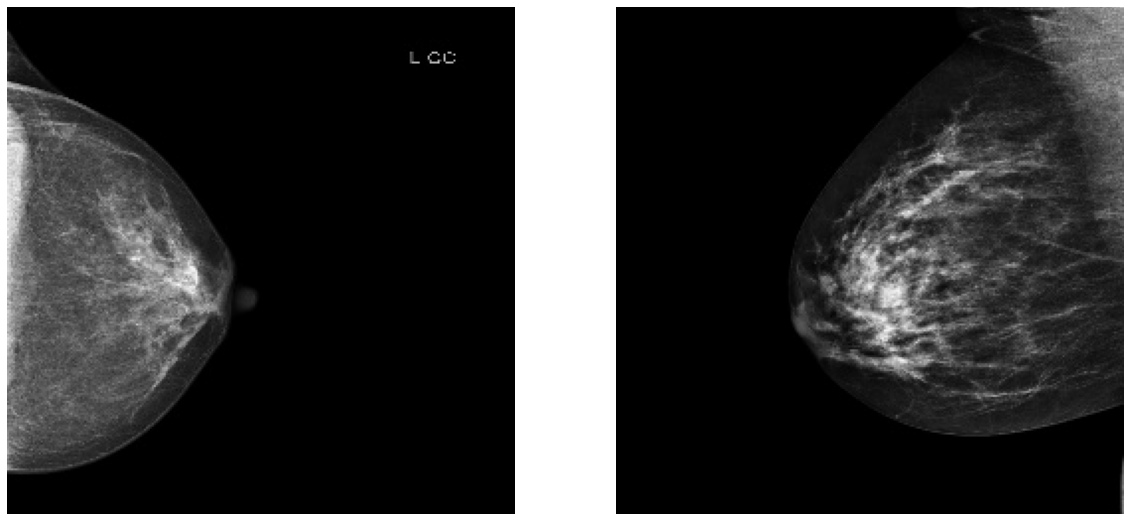

In [42]:
"""In this cell, I will be declaring the Dataset class, which will be used to load the images and the labels.
"""
df = pd.read_csv('../data/train.csv')
# df.sort_values(by='patient_id', inplace=True)
path_images = '../data/256_images/'
list_images = sorted(os.listdir(path_images))

# I will need a torch Dataset to load the images and the labels.
class DatasetBreastWrong(torch.utils.data.Dataset):
    """The labels will be available through df.cancer, whereas the images will be loaded from the /data/256_images folder.
    """
    def __init__(self, df, path_patients, transform=None):
        self.df = df
        self.path_patients = path_patients
        self.transform = transform
        self.list_patients = sorted(os.listdir(path_patients))
        self.list_patients = [x for x in self.list_patients if x != '.DS_Store']
        # From the list of patients, I will need to get access to the images
        self.list_images = []
        for patient in self.list_patients:
            for image in sorted(os.listdir(path_images + patient)):
                if image != '.DS_Store':
                    self.list_images.append(patient + '/' + image)
        self.list_images = sorted(self.list_images)
        self.labels = self.df.cancer.values
        self.labels = self.labels.astype(np.float32)
        self.labels = torch.from_numpy(self.labels)

    def __len__(self):
        return len(self.list_images)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        # Get the image
        path_image = self.path_patients + self.list_images[idx]
        image = plt.imread(path_image)
        image = image.astype(np.float32)
        image = torch.from_numpy(image)
        image = image.permute(2, 0, 1)
        # Get the label it should be either 0 or 1
        label = self.labels[idx]
        sample = {'image': image, 'label': label}
        if self.transform:
            sample = self.transform(sample)
        return sample
    

dataset_wrong = DatasetBreastWrong(df, path_images)
# print(dataset_wrong.list_images)
# Check if it is working
sample = dataset_wrong[5]
sample2 = dataset_wrong[20]
print(sample['image'].shape)
print(sample['label'])

# Show the image as a numpy array int32
plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.imshow(sample['image'].permute(1, 2, 0).numpy().astype(np.int32))
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(sample2['image'].permute(1, 2, 0).numpy().astype(np.int32))
plt.axis('off')
plt.show()


### Dataset with just one modality

torch.Size([3, 256, 256])
tensor(0.)


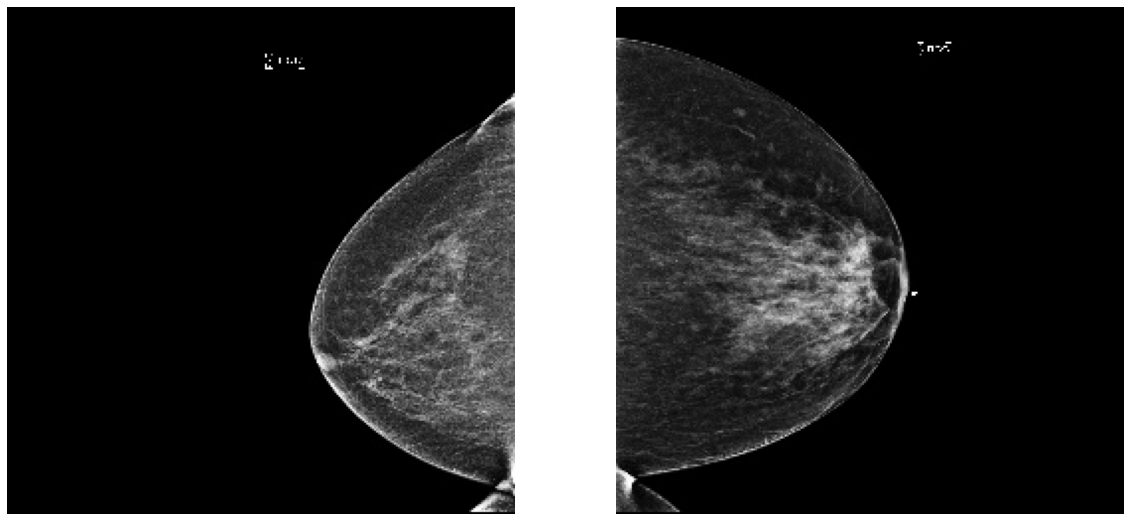

In [44]:
"""In this cell, I will create the proper Dataset object, using just one view like CC or MLO.

The dataset will consider the heavy inbalance of the data, so I will downsample the majority class.
"""
class DatasetBreastDownsample(torch.utils.data.Dataset):
    """The labels will be available through df.cancer, whereas the images will be loaded from the /data/256_images folder.
    """
    def __init__(self, df, path_patients, transform=None, view='CC', breast = 'R'):
        # From the dataframe, I will need to remove the images that are not the view I want. 
        # I will also need to remove the images that are not the breast I want.
        # Finally, I need to downsample the majority class. 
        self.df = df
        self.path_patients = path_patients
        self.transform = transform
        self.view = view
        self.breast = breast

        # I need to randomly select the patients that are in the majority class
        self.list_patients_majority = np.unique(self.df.patient_id[(self.df.cancer == 0).values])
        self.list_patients_minority = np.unique(self.df.patient_id[(self.df.cancer == 1).values])
        # I will need to downsample the majority class

        self.list_patients_majority = np.random.choice(self.list_patients_majority, 
                                                       size=len(self.list_patients_minority), 
                                                       replace=False)
        
        self.list_patients = np.concatenate((self.list_patients_majority, 
                                             self.list_patients_minority))
        
        # Working with the dataframe
        self.df = self.df[self.df.view == self.view]
        self.df = self.df[self.df.laterality == self.breast]
        # Reduce the dataframe to only have the list of patients
        self.df = self.df[self.df.patient_id.isin(self.list_patients)]

        # From the df, I will need to construct the list of paths for the desired images, the format will be patient_id/image_id.dcm
        self.list_images = []
        for patient in self.list_patients:
            for image in self.df.image_id[self.df.patient_id == patient].values:
                self.list_images.append(str(patient) + '/' + str(image) + '.jpg')
        self.list_images = sorted(self.list_images)
        self.labels = self.df.cancer.values
        self.labels = self.labels.astype(np.float32)
        self.labels = torch.from_numpy(self.labels)

    def __len__(self):
        return len(self.list_images)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        # Get the image
        path_image = self.path_patients + self.list_images[idx]
        image = plt.imread(path_image)
        image = image.astype(np.float32)
        image = torch.from_numpy(image)
        image = image.permute(2, 0, 1)
        # Get the label it should be either 0 or 1
        label = self.labels[idx]
        sample = {'image': image, 'label': label}
        if self.transform:
            sample = self.transform(sample)
        return sample


dset_trial = DatasetBreastDownsample(df, path_images, view='CC', breast='R')
# Check if it is working
sample = dset_trial[5]
sample2 = dset_trial[20]
print(sample['image'].shape)
print(sample['label'])

# Show the image as a numpy array int32
plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.imshow(sample['image'].permute(1, 2, 0).numpy().astype(np.int32))
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(sample2['image'].permute(1, 2, 0).numpy().astype(np.int32))
plt.axis('off')
plt.show()

In [30]:
df.patient_id[df.cancer == 1].values

array([10130, 10130, 10130, ...,  9840,  9851,  9851])

### Train-validation-test split

In [9]:
# Train-validation-test split
train_size = int(0.8 * len(dataset_down))
val_size = int(0.1 * len(dataset_down))
test_size = len(dataset_down) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset_down, [train_size, val_size, test_size])

# Create the dataloaders
size_batch = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=size_batch, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=size_batch, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=size_batch, shuffle=True)

# Check if it is working
for i_batch, sample_batched in enumerate(train_loader):
    print(i_batch, sample_batched['image'].size(), sample_batched['label'])
    if i_batch == 3:
        break


0 torch.Size([32, 3, 256, 256]) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
1 torch.Size([32, 3, 256, 256]) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
2 torch.Size([32, 3, 256, 256]) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
3 torch.Size([32, 3, 256, 256]) tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])


### Baseline Model (2D - Convolutional Neural Network)

In [17]:
"""Create 2D convolutional neural network for the classification task of the cancer images (binary classification), based on images 3x256x256. I will be using a mini batch size of 32"""

# Create a model
model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 5, stride = 1, padding = 1))
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size = 2, stride = 2))
model.add_module('conv2', nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 5, stride = 1, padding = 1))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size = 2, stride = 2))
model.add_module('conv3', nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 5, stride = 1, padding = 1))
model.add_module('relu3', nn.ReLU())
model.add_module('pool3', nn.MaxPool2d(kernel_size = 2, stride = 2))
model.add_module('conv4', nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 5, stride = 1, padding = 1))
model.add_module('relu4', nn.ReLU())
model.add_module('pool4', nn.MaxPool2d(kernel_size = 2, stride = 2))
model.add_module('conv5', nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 5, stride = 1, padding = 1))
model.add_module('relu5', nn.ReLU())
model.add_module('pool5', nn.MaxPool2d(kernel_size = 2, stride = 2))

model.add_module('flatten', nn.Flatten())
model.add_module('fc1', nn.Linear(in_features = 9216, out_features = 256))
model.add_module('relu6', nn.ReLU())
model.add_module('fc2', nn.Linear(in_features = 256, out_features = 64))
model.add_module('relu7', nn.ReLU())
model.add_module('fc3', nn.Linear(in_features = 64, out_features = 32))
model.add_module('relu8', nn.ReLU())
model.add_module('fc4', nn.Linear(in_features = 32, out_features = 8))
model.add_module('relu9', nn.ReLU())
model.add_module('fc5', nn.Linear(in_features = 8, out_features = 1))
model.add_module('sigmoid', nn.Sigmoid())



# Check if it is working
# sample = dataset[5]
# sample2 = dataset[20]
# print(sample['image'].shape)
# print(sample['label'])
# print(model(sample['image'].unsqueeze(0)).item())
# print(model(sample2['image'].unsqueeze(0)).item())

# Summary
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 254, 254]           2,432
              ReLU-2         [-1, 32, 254, 254]               0
         MaxPool2d-3         [-1, 32, 127, 127]               0
            Conv2d-4         [-1, 32, 125, 125]          25,632
              ReLU-5         [-1, 32, 125, 125]               0
         MaxPool2d-6           [-1, 32, 62, 62]               0
            Conv2d-7           [-1, 64, 60, 60]          51,264
              ReLU-8           [-1, 64, 60, 60]               0
         MaxPool2d-9           [-1, 64, 30, 30]               0
           Conv2d-10          [-1, 128, 28, 28]         204,928
             ReLU-11          [-1, 128, 28, 28]               0
        MaxPool2d-12          [-1, 128, 14, 14]               0
           Conv2d-13          [-1, 256, 12, 12]         819,456
             ReLU-14          [-1, 256,

 10%|█         | 1/10 [33:49<5:04:25, 2029.46s/it]

Epoch [1/10], Loss: 2.1336, Accuracy: 97.87%


 20%|██        | 2/10 [1:07:29<4:29:53, 2024.17s/it]

Epoch [2/10], Loss: 2.1350, Accuracy: 97.87%


 30%|███       | 3/10 [1:41:08<3:55:49, 2021.40s/it]

Epoch [3/10], Loss: 2.1350, Accuracy: 97.87%


 40%|████      | 4/10 [2:14:45<3:21:58, 2019.71s/it]

Epoch [4/10], Loss: 2.1350, Accuracy: 97.87%


 50%|█████     | 5/10 [2:48:18<2:48:07, 2017.49s/it]

Epoch [5/10], Loss: 2.1336, Accuracy: 97.87%


 60%|██████    | 6/10 [3:21:57<2:14:31, 2017.96s/it]

Epoch [6/10], Loss: 2.1336, Accuracy: 97.87%


 70%|███████   | 7/10 [3:55:58<1:41:16, 2025.43s/it]

Epoch [7/10], Loss: 2.1336, Accuracy: 97.87%


 80%|████████  | 8/10 [4:30:06<1:07:45, 2032.81s/it]

Epoch [8/10], Loss: 2.1363, Accuracy: 97.87%


 90%|█████████ | 9/10 [5:03:39<33:46, 2026.36s/it]  

Epoch [9/10], Loss: 2.1336, Accuracy: 97.87%


100%|██████████| 10/10 [5:37:11<00:00, 2023.17s/it]

Epoch [10/10], Loss: 2.1336, Accuracy: 97.87%


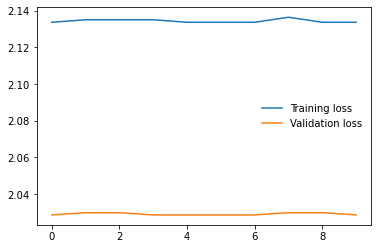

In [23]:
# Train the model 

# Define the loss function
criterion = nn.BCELoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0]*num_epochs
    loss_hist_valid = [0]*num_epochs
    accuracy_hist_train = [0]*num_epochs
    accuracy_hist_valid = [0]*num_epochs
    for epoch in tqdm.tqdm(range(num_epochs)):
        model.train()
        for i, sample_batched in enumerate(train_dl):
            optimizer.zero_grad()
            outputs = model(sample_batched['image'])
            loss = criterion(outputs, sample_batched['label'].unsqueeze(1))
            loss.backward()
            optimizer.step()
            loss_hist_train[epoch] += loss.item()
            accuracy_hist_train[epoch] += (outputs.round() == sample_batched['label'].unsqueeze(1)).sum().item()
        loss_hist_train[epoch] /= len(train_dl)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        model.eval()
        with torch.no_grad():
            for i, sample_batched in enumerate(valid_dl):
                outputs = model(sample_batched['image'])
                loss = criterion(outputs, sample_batched['label'].unsqueeze(1))
                loss_hist_valid[epoch] += loss.item()
                accuracy_hist_valid[epoch] += (outputs.round() == sample_batched['label'].unsqueeze(1)).sum().item()
        loss_hist_valid[epoch] /= len(valid_dl)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch+1, num_epochs, loss_hist_train[epoch], accuracy_hist_train[epoch]*100))
    return model, loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid
num_epochs = 10

model, loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid = train(model, num_epochs, train_loader, val_loader)

# Plot the loss and accuracy
plt.plot(loss_hist_train, label='Training loss')
plt.plot(loss_hist_valid, label='Validation loss')
plt.legend(frameon=False)
plt.show()



Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


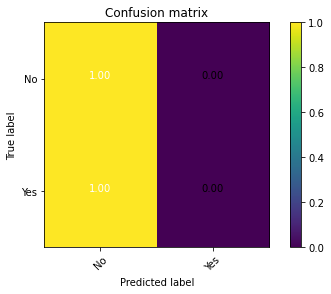

In [29]:
# Plot the confussion matrix
def plot_confusion_matrix(cm, classes,
                            normalize=False,
                            title='Confusion matrix',
                            ):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')
    
        print(cm)
    
        plt.imshow(cm, interpolation='nearest')
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)
    
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

# Confusion matrix
y_pred = []
y_true = []
with torch.no_grad():
    for i, sample_batched in enumerate(val_loader):
        outputs = model(sample_batched['image'])
        y_pred.extend(outputs.round().tolist())
        y_true.extend(sample_batched['label'].tolist())
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, classes=['No', 'Yes'], normalize=True)
